<a href="https://colab.research.google.com/github/amineHY/Image-classification-of-MNIST/blob/master/pytorch_mnist_deep_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from  MNIST dataset using Convolutional Neural Network

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(777)  # reproducibility

tensor([1.], device='mps:0')


In [2]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    exit()

In [3]:
### assign the using device to variable
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
# hyper-parameters
batch_size = 32
keep_prob = 1 # 0.7

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

In [22]:
mnist_train.data.size()

torch.Size([60000, 28, 28])

In [6]:
# Display informations about the dataset
print('The training dataset:\t',mnist_train)
print('\nThe testing dataset:\t',mnist_test)

The training dataset:	 Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()

The testing dataset:	 Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()


The CNN architecture we used in this notebook is proposed [ here ](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/index.html)

![Architecture of the CNN…](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

In [7]:
# Implementation of CNN/ConvNet Model using PyTorch (depicted in the picture above)

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN().to(device) ### <= move the model to the using device
model

/var/folders/_b/mvxt480d0h5202lsn8_qnpx80000gn/T/ipykernel_7788/2528615903.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

### Affichage des parametres du réseaux pour chaque couche

*   Weight
*   Biais



In [8]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([10, 625])
torch.Size([10])


### Definition de la fonction cout et l'algorithme d'optimisation

In [9]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

The cross-entropy cost function is defined as follow : 
$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
= -x[class] + \log\left(\sum_j \exp(x[j])\right)$

## Apprentissage du modèle

In [23]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 15
total_batch = len(mnist_train) // batch_size

print('Size of the training dataset is {}'.format(mnist_train.data.size()))
print('Size of the testing dataset'.format(mnist_test.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = Variable(batch_X).to(device)   # image is already size of (28x28), no reshape
        Y = Variable(batch_Y).to(device)    # label is not one-hot encoded
        print(X.shape)
#
#         optimizer.zero_grad() # <= initialization of the gradients
#
#         # forward propagation
#         hypothesis = model(X)
#         cost = criterion(hypothesis, Y) # <= compute the loss function
#
#         # Backward propagation
#         cost.backward() # <= compute the gradient of the loss/cost function
#         optimizer.step() # <= Update the gradients
#
#         # Print some performance to monitor the training
#         prediction = hypothesis.data.max(dim=1)[1]
#         train_accu.append(((prediction.data == Y.data).float().mean()).item())
#         train_cost.append(cost.item())
#         if i % 200 == 0:
#             print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
#
#         avg_cost += cost.data / total_batch
#
#     print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))
#
#
# print('Learning Finished!')
# # _, argmax = torch.max(outputs, 1)
# # accuracy = (labels == argmax.squeeze()).float().mean()

Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset
Batch size is : 32
Total number of batches is : 1875

Total number of epochs is : 15
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torc

### Afficher la courbe du critère lors de l'apprentissage

(<Axes: >, [<matplotlib.lines.Line2D at 0x2b1f0b070>], (0.0, 100.0))

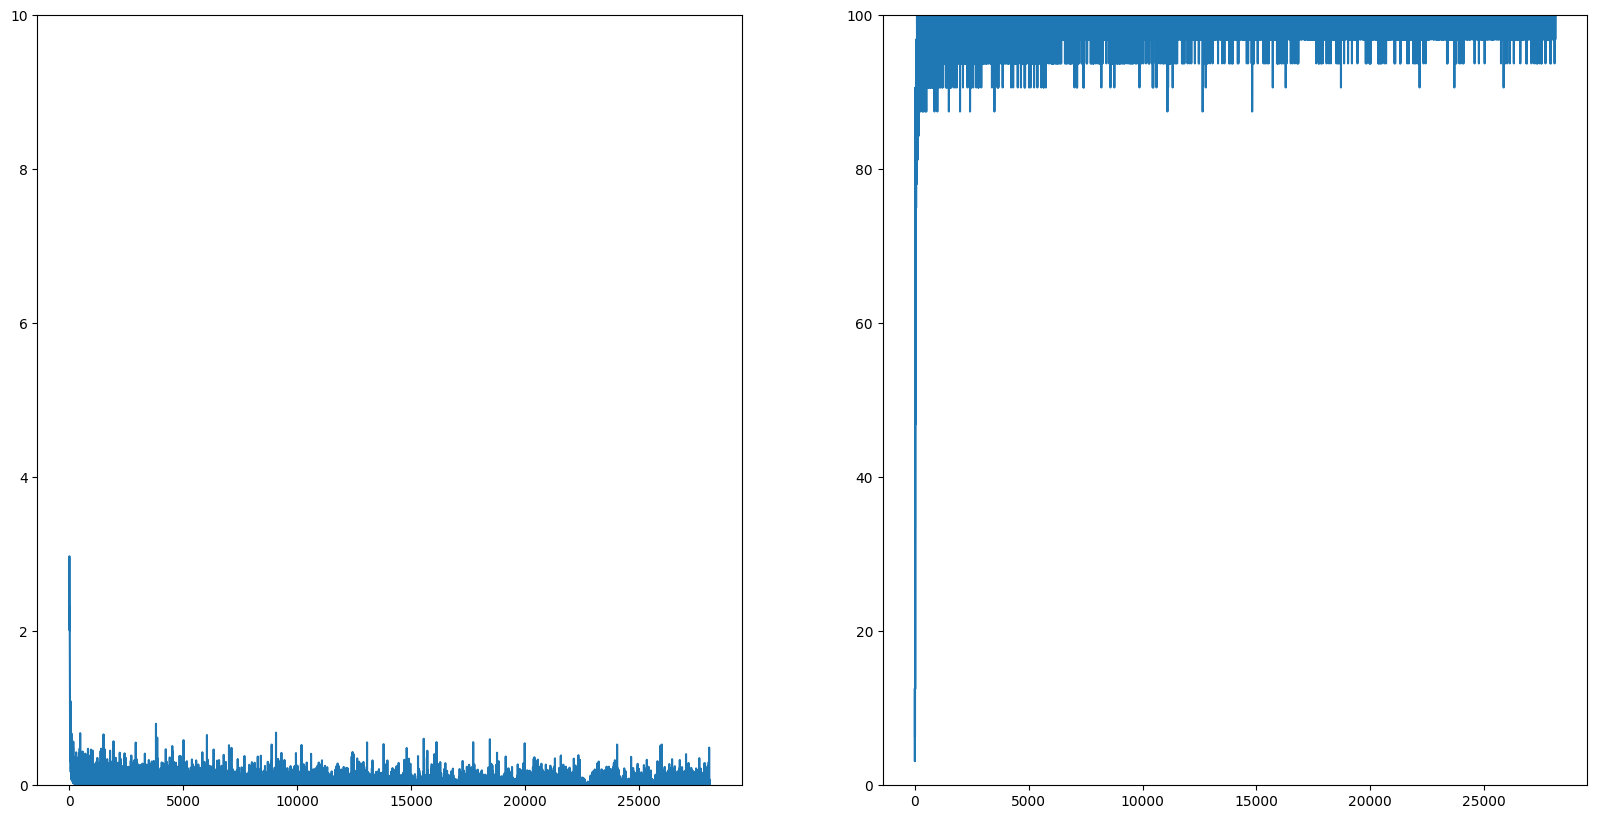

In [11]:
from matplotlib import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])



In [12]:
cost.item?

In [13]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(mnist_test.data.view(len(mnist_test), 1, 28, 28).float()).to(device)
Y_test = Variable(mnist_test.targets).to(device)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 87.67 %


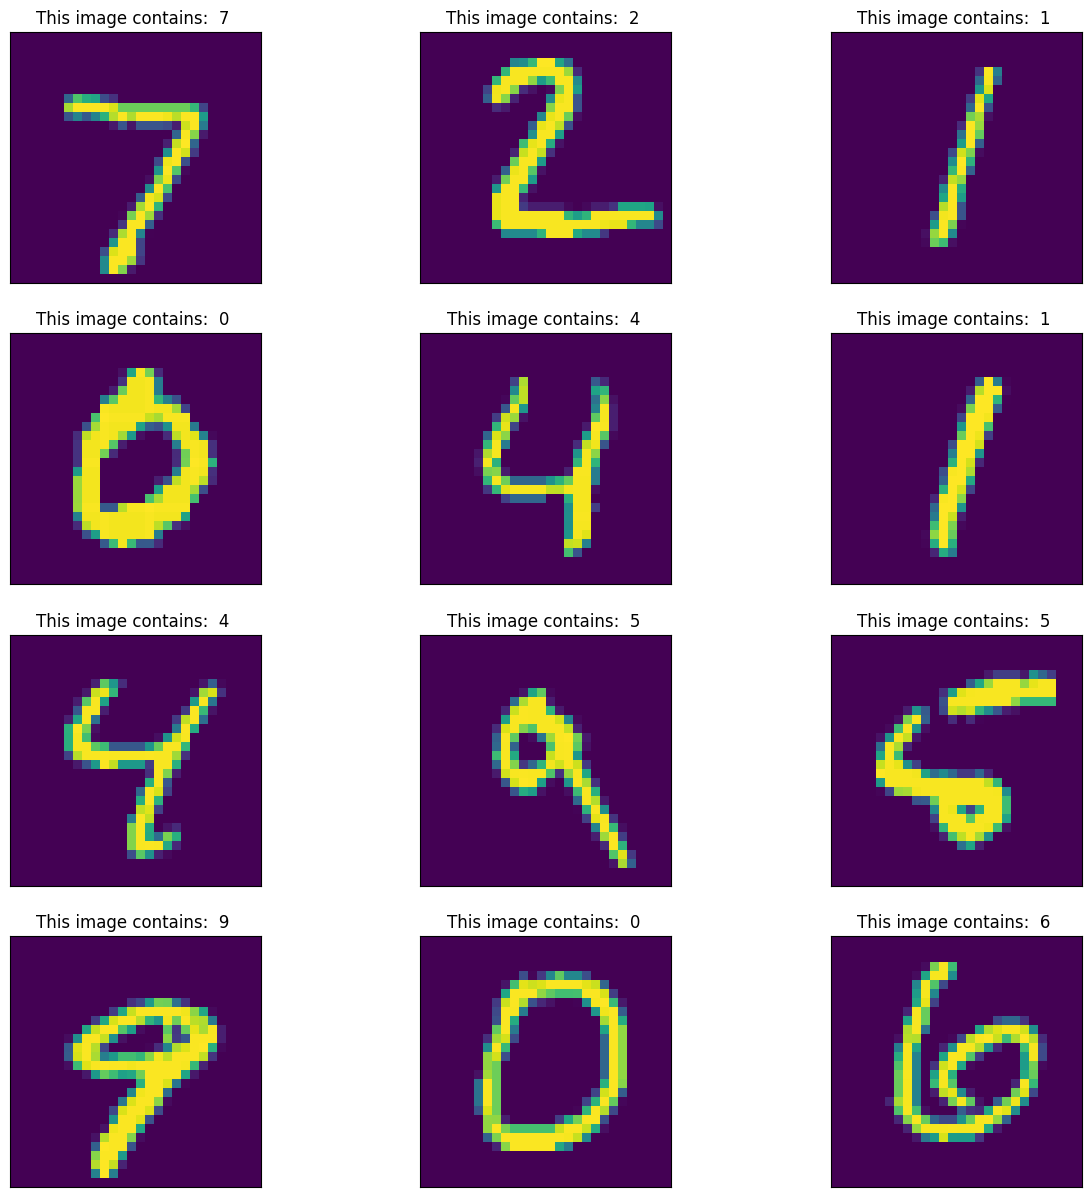

In [18]:
from matplotlib import pylab as plt



plt.figure(figsize=(15,15), facecolor='white')
for i in np.arange(0,12):
  val, idx = torch.max(prediction, dim=1)
  plt.subplot(4,3,i+1)
  plt.imshow(X_test[i][0].cpu())
  plt.title('This image contains: {0:>2} '.format(idx[i].item()))
  plt.xticks([]), plt.yticks([])
  plt.plt.subplots_adjust()

In [19]:
11/12

0.9166666666666666